In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
#import src.beachball.ptaxis as pt
import ball as bb
from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse
import nzborders as nzb
#import slabeventclassify as evc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pyslabgrid import slabeventclassify as evc

#####  Tasks:
- identify intraslab earthquakes recorded in the GeoNet moment tensor catalogue, and 
- plot a map depicting the beachballs. 

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

In [3]:
def warpToMax(x, Max=360):
    return (x%Max)
# simple
def get_plotbeachballs(lons, lats, strikes, dips, rakes, width=2):
    patches_list = []
    color_list = []
    for i in range(len(lons)):
        a, collect = bb.plotbb(strikes[i],dips[i], rakes[i], \
                               xy = (lons[i], lats[i]), width=width);
        
        ellipse = Ellipse(xy=(lons[i], lats[i]), width=width+0.05, height=width+0.05, 
                        edgecolor='k', fc=None, lw=0.03)
        
        patches_list.append(ellipse)
        color_list.append('k')
        
        patches_list.append(collect[0])
       
        if (rakes[i]>45) & (rakes[i]<135):
            color_list.append('b')
        elif (rakes[i]<-45) & (rakes[i]>-135):
            color_list.append('g')
        else:
            color_list.append('r')
        
        patches_list.append(collect[1])
        color_list.append('w')

    our_cmap = ListedColormap(color_list)
    beachballs = PatchCollection(patches_list, cmap=our_cmap)
    beachballs.set_array(np.arange(len(patches_list)))
    return beachballs

In [4]:
#fname = '../data/geonet/GeoNet-v04-tectclass.csv'
fname = '../data/geonet/GeoNet_CMT_solutions.csv'
lat, lon, Mw, dep = [],[],[], []
strike1,dip1,rake1,strike2,dip2,rake2 = ([],[],[],[],[],[])
with open(fname, 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    # print(header)
    lat_index = header.index('Latitude')
    lon_index = header.index('Longitude')
    
    dep_index = header.index('CD')
    Mw_index = header.index('Mw')
    strike1_index = header.index('strike1')
    dip1_index = header.index('dip1')
    rake1_index = header.index('rake1')
    strike2_index = header.index('strike2')
    dip2_index = header.index('dip2')
    rake2_index = header.index('rake2')
    
    for row in csvreader:
        if evc.within_interfacezone(float(row[lon_index]), float(row[lat_index])) is None:
            continue
        lat.append(float(row[lat_index]))
        lon.append(float(row[lon_index]))
        dep.append(float(row[dep_index]))
        Mw.append(float(row[Mw_index]))
        strike1.append(float(row[strike1_index]))
        dip1.append(float(row[dip1_index]))
        rake1.append(float(row[rake1_index]))
        strike2.append(float(row[strike2_index]))
        dip2.append(float(row[dip2_index]))
        rake2.append(float(row[rake2_index]))
            
lon = [warpToMax(x) for x in lon]
# perhaps - remove Mw <4.0
# Mxx,Mxy,Mxz,Myy,Myz,Mzz

In [5]:

fout = open('GeoNet_slabevents.csv', 'w')
fout.write('lon,lat,dep,Mw,strike1,dip1,rake1,strike2,dip2,rake2')
fixed_parameters = {'Hmax_interface': 80, # maximum depth
                     'interface_buffer': [10, 10],
                     'Hmax_crust': 40,
                     'min_depth': 0,
                     'max_depth': 500, # tentative
                    }
for x,y,z,m,s1,d1,r1,s2,d2,r2 in zip(lon, lat, dep, Mw, strike1, dip1, rake1, strike2, dip2, rake2):
    if evc.is_slabevent(x,y, z, fixed_parameters = fixed_parameters):
        fout.write('\n%.4f,%.4f,%.4f,%.3f,%.4f,%.4f,%.4f,%.4f,%.4f,%.4f' \
            %(x,y,z,m,s1,d1,r1,s2,d2,r2))
fout.close()

In [6]:
with open('GeoNet_slabevents.csv', 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    slat,slon,sdep,sMw,s1,d1,r1,s2,d2,r2 = [],[],[],[],[],[],[],[],[],[]
    hik_count, puy_count = 0,0
    # 'lon,lat,dep,Mw,strike1,dip1,rake1,strike2,dip2,rake2'
    for row in csvreader:
        if float(row[2])>300:
            continue
      
        slat.append(float(row[1]))
        slon.append(float(row[0]))
        sdep.append(float(row[2]))
        sMw.append(float(row[3]))
        s1.append(float(row[4]))
        d1.append(float(row[5]))
        r1.append(float(row[6]))
        s2.append(float(row[7]))
        d2.append(float(row[8]))
        r2.append(float(row[9]))
        
        if evc.within_interfacezone(float(row[0]), float(row[1]))=='hik':
            hik_count +=1
        elif evc.within_interfacezone(float(row[0]), float(row[1]))=='puy':
            puy_count +=1

print("number of events in Hikurangi: " + str(hik_count))
print("number of events in Puysegur: " + str(puy_count))
 

number of events in Hikurangi: 399
number of events in Puysegur: 76


In [7]:
# %matplotlib notebook
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
# ax.plot3D(slon, slat, sdep,'o', color='b');
# ax.invert_zaxis()

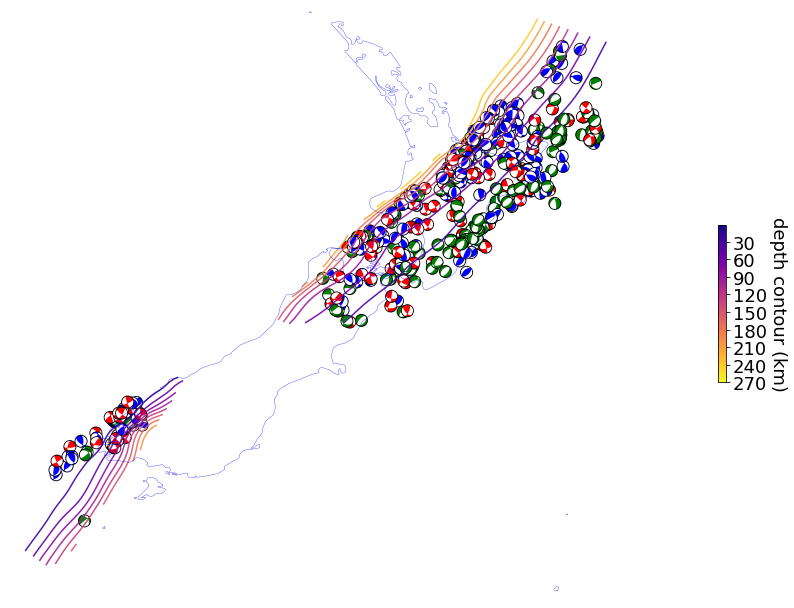

In [11]:
%matplotlib inline

# sort on Mw
sort_indx = sorted(range(len(sMw)), key=lambda k: sMw[k], reverse=True)
sslon, sslat, ss1, dd1, rr1 = [],[],[],[],[]
for i in sort_indx:
    sslon.append(slon[i])
    sslat.append(slat[i])
    ss1.append(s1[i])
    dd1.append(d1[i])
    rr1.append(r1[i])
    
beachballs = get_plotbeachballs(sslon, sslat, ss1, dd1, rr1, width=0.3)
#beachballs = get_plotbeachballs(slon, slat, s1, d1, r1, width=0.3)

fig = plt.figure(figsize=(12,15))

ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 13})
import mat
import matplotlib.colors as colors
subdmod =  mat.getdict('../data/subduction_model/subduction_model.mat')
X = subdmod['hik']['lon_interface']
Y = subdmod['hik']['lat_interface']
Z = subdmod['hik']['dep_interface']
cs = ax.contour(X, Y, Z, 9, cmap='plasma', alpha = 0.9)
X = subdmod['puy']['lon_interface']
Y = subdmod['puy']['lat_interface']
Z = subdmod['puy']['dep_interface']
ax.contour(X, Y, Z, 9, cmap='plasma', alpha = 0.9, vmax=cs.cvalues.max())
#plt.colorbar()

norm= colors.Normalize(vmin=1, vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, ticks=cs.levels, shrink =0.15)
cbar.ax.tick_params(labelsize=18)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('depth contour (km)', rotation=270, fontsize=18)
cbar.ax.invert_yaxis()

nzb.plot(plinewidth= 0.3, pcolor = 'b', ax=ax)
ax.add_collection(beachballs)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('longitude ($^\circ$E)', fontsize = 13);
plt.ylabel('latitude ($^\circ$N)', fontsize = 13);
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.xlim([164,182])
plt.ylim([-50, -34]);
ax.set_axis_off()
plt.tight_layout()
plt.savefig('beachballs.png', dpi=300)